### Discovery

In [1]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
from catboost import Pool, cv, CatBoostClassifier
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

### Misinfo classifier

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_importances(importances, features, name):
    plt.figure(figsize=(20, 3))
    plt.bar(range(len(features)), importances, tick_label=features)
    plt.xticks(rotation = 45)
    plt.title(name + ' Feature Importances')
    plt.grid()
    plt.show()

df = pd.read_csv ('../data/filtered_attrs.csv')
df_filtered = df.copy()
df_filtered.reset_index(drop=True, inplace=True)

for row, label in enumerate(df_filtered['label']):
    if label > 4:
        df_filtered['label'][row] = 0
    else:
        df_filtered['label'][row] = 1

dropped_cols = ['label', 'url', 'source']
X = df_filtered.drop(columns = dropped_cols)
y = df_filtered['label']
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_filtered.index, test_size=0.2, shuffle=True)

misinfo_clf = CatBoostClassifier(verbose=False, random_state=0)
misinfo_clf = misinfo_clf.fit(X_train, y_train)

/tmp/ipykernel_10854/2128581879.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'][row] = 1
/tmp/ipykernel_10854/2128581879.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'][row] = 0


### News classifier

/tmp/ipykernel_10854/2744546945.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_crawl_10k_labelled.drop(columns=['result'], inplace=True)
/tmp/ipykernel_10854/2744546945.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_crawl_10k_labelled['is_news'] = 0
/tmp/ipykernel_10854/2744546945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

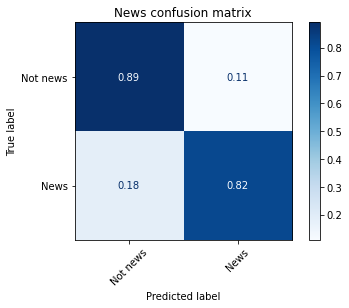

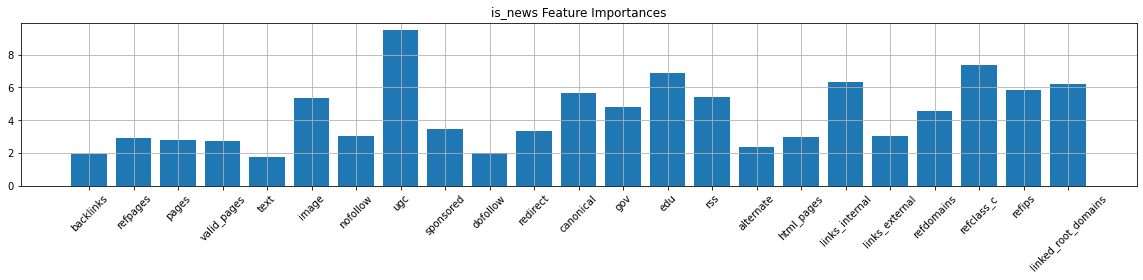

F1: 0.8288770053475936
Acc: 0.8593406593406593


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

common_crawl_sm_df = pd.read_csv('common_crawl_sample.csv')
common_crawl_inf = common_crawl_sm_df.drop(columns=['url'])
common_crawl_res = misinfo_clf.predict(common_crawl_inf)
common_crawl_sm_df['result'] = common_crawl_res
common_crawl_10k_labelled = common_crawl_sm_df[common_crawl_sm_df['backlinks']>=10000]
common_crawl_10k_labelled.drop(columns=['result'], inplace=True)
common_crawl_10k_labelled['is_news'] = 0
common_crawl_10k = common_crawl_10k_labelled.drop(columns=['url'])
common_crawl_10k_labelled['label'] = 0

pos_examples_labelled = df_filtered.sample(n=900, random_state=0)
pos_examples_labelled['is_news'] = 1
pos_examples_labelled.drop(columns=['source'], inplace=True)
pos_examples = pos_examples_labelled.drop(columns=['url', 'label'])
news_df_labelled = pd.concat([common_crawl_10k_labelled, pos_examples_labelled], ignore_index=True)
news_df = pd.concat([common_crawl_10k, pos_examples], ignore_index=True)
news_df.dropna(inplace=True)
news_X_train, news_X_test, news_y_train, news_y_test, news_ind_train, news_ind_test = \
    train_test_split(news_df.drop(columns='is_news'), news_df['is_news'], news_df.index, test_size=0.2, shuffle=True)

news_clf = CatBoostClassifier(verbose=False, random_state=0)
news_clf = news_clf.fit(news_X_train, news_y_train)

news_disp = ConfusionMatrixDisplay.from_estimator(
    news_clf,
    news_X_test,
    news_y_test,
    display_labels=['Not news', 'News'],
    cmap=plt.cm.Blues,
    normalize="true",
)
news_disp.ax_.set_title('News confusion matrix')

plt.xticks(rotation = 45)
plt.show()

plot_importances(news_clf.get_feature_importance(), news_X_train.columns, 'is_news')

from sklearn.metrics import accuracy_score, f1_score
_preds = news_clf.predict(news_X_test)
_f1 = f1_score(news_y_test, np.rint(_preds))
_acc = accuracy_score(news_y_test, np.rint(_preds))
print("F1:",_f1)
print("Acc:", _acc)

### Bias Classifier

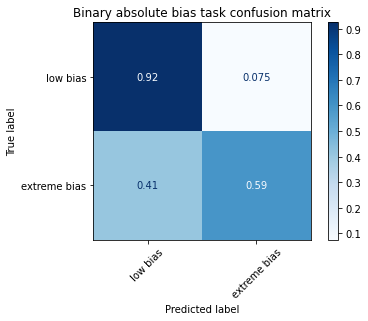

0.8365019011406845
AUC: 0.6587301587301587


In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
bias_df = pd.read_csv ('../data/bias_labels.csv')
bias_df.rename(columns={'domain':'url', 'bias':'bias'}, inplace=True)
bias_df.drop_duplicates(subset='url', inplace=True)
bias_df['url'].str.strip()
df_with_bias = pd.merge(bias_df,df_filtered, on='url', how='inner')
binary_bias_map = {
    -2: 1,
    -1: 0,
    0: 0,
    1: 0, 
    2: 1,
}
df_binary_bias = df_with_bias.copy()
df_binary_bias["bias"].replace(binary_bias_map, inplace=True)

X = df_binary_bias.drop(columns = (dropped_cols + ['bias']))

y = df_binary_bias['bias'].abs()
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_binary_bias.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
abs_bin_bias_clf = clfs["Boosted DT"]
abs_bin_bias_clf = abs_bin_bias_clf.fit(X_train, y_train)

scores = abs_bin_bias_clf.predict(X_test)
predictions = np.rint(scores)

disp = ConfusionMatrixDisplay.from_estimator(
    abs_bin_bias_clf,
    X_test,
    y_test,
    display_labels=['low bias', 'extreme bias'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Binary absolute bias task confusion matrix')
plt.xticks(rotation = 45)
plt.show()


print(accuracy_score(y_test, predictions))
print(f"AUC: {f1_score(y_test, predictions)}")

abs_bin_bias_clf.save_model('model_bias_mbfc')

### Discovery among link scheme outlinks

In [7]:
def get_misinfo(seo_attributed_sites, news_clf, misinfo_clf, bias_clf):
    seo_attributed_sites = seo_attributed_sites[seo_attributed_sites['backlinks']>10000]
    seo_attributed_sites['is_news'] = news_clf.predict_proba(seo_attributed_sites.drop(columns='url'))[:, 1]
    seo_attributed_sites['is_misinfo'] = misinfo_clf.predict_proba(seo_attributed_sites.drop(columns=['url','is_news']))[:, 1]
    seo_attributed_sites['is_biased'] = bias_clf.predict_proba(seo_attributed_sites.drop(columns=['url','is_news','is_misinfo']))[:, 1]
    return seo_attributed_sites[['url','is_news','is_misinfo','is_biased']]

outlinks_df = pd.read_csv('../data/link_scheme_outlink_attrs.csv')
outlinks_df = outlinks_df.merge(right=df_filtered[['url']], on='url', how='left', indicator=True)
outlinks_df = outlinks_df[outlinks_df['_merge'] == 'left_only']
outlinks_df = outlinks_df.drop(columns=['_merge'])
outlinks_preds_df = get_misinfo(outlinks_df, news_clf, misinfo_clf, abs_bin_bias_clf)
discovered_misinfo = outlinks_preds_df.query('is_news > 0.5 & is_misinfo > 0.5 & is_biased > 0.5')
discovered_misinfo.describe()


/tmp/ipykernel_10854/45927234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seo_attributed_sites['is_news'] = news_clf.predict_proba(seo_attributed_sites.drop(columns='url'))[:, 1]
/tmp/ipykernel_10854/45927234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seo_attributed_sites['is_misinfo'] = misinfo_clf.predict_proba(seo_attributed_sites.drop(columns=['url','is_news']))[:, 1]
/tmp/ipykernel_10854/45927234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,is_news,is_misinfo,is_biased
count,1308.000000,1308.000000,1308.000000
mean,0.736869,0.849453,0.831571
std,0.140242,0.133765,0.129544
min,0.500056,0.501481,0.502107
25%,0.610542,0.767185,0.738388
50%,0.742065,0.899010,0.871087
75%,0.860917,0.958790,0.939540
max,0.991222,0.997689,0.994920


In [8]:
import datetime

misinfo_sample = discovered_misinfo.sample(200,random_state=42)
discovered_misinfo.to_csv(f'../results/discovered_domains_{datetime.datetime.now()}.csv', index=False)
misinfo_sample.to_csv(f'../results/discovered_domains_sample_{datetime.datetime.now()}.csv', index=False)